
### Analysis of the 2017 Thomas Fire

Author: Tom Gibbens-Matsuyama (tommats00\@github.io)

<img src="https://camo.githubusercontent.com/eb96c7e74feb1cad555d796e03bf71e25a4f38058ba619e1e4da5c6a8d86330d/68747470733a2f2f7777772e6c6965666663616272617365722e636f6d2f77702d636f6e74656e742f75706c6f6164732f77696c64666972652d736c6964652d3530302e6a7067" alt="Thomas Fire 2017">

Image Credits: Carsten Shertzer \| Getty Images

# About

### Purpose

In December of 2017, one of California's largest wildfires burned over 280,000 acres of land in Ventura and Santa Barbara counties. The purpose of this analysis is to do the following: visualize how the Air Quality Index (AQI) was effected in Santa Barbara County and produce a false color image containing the Thomas Fire boundary.

### Highlights of analysis:

-   Use `pandas` to read in tabular data
-   Use `rioxarray` and `geopandas` to read in spatial data
-   Read data from a link and local source
-   Filter and transform tabular data types with `pandas`
-   Filter and transform spatial data with `rioxarray` and `geopandas`
-   Visualize filtered AQI data
-   Visualize filtered landsat and boundary data

## Dataset descriptions:

#### AQI Data

[AQI data](https://www.airnow.gov/aqi/aqi-basics/) from the [US Environmental Protection Agency (EPA)](https://www.epa.gov/) will be used to visualize the impact of the 2017 Thomas Fire in Santa Barbara County. This data comes from these [pre-generated data files](https://aqs.epa.gov/aqsweb/airdata/download_files.html). These files are updated twice a year, once in June to capture the entire previous year and once in December to capture the Summer.

#### Landsat Collection 2 Level-2 data from Landsat 8

This dataset is a collection of bands from the Landsat Collection 2 Level-2 collected by the Landsat 8 satellite. This data was taken from the [Microsoft Planetary Computer data catalogue](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) and pre-processed for our use.

#### California Fire Perimeters

The second dataset is a pre-processed geospatial data frame from [Data.gov](https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436). This dataset contains the Thomas Fire perimeter data.


### Load libraries

In [1]:
#| code-fold: true
#| code-summary: Show the code
# Core library
import pandas as pd 

# For loading in geospatial data
import geopandas as gpd
import rioxarray as rioxr

# For plotting 
import matplotlib.pyplot as plt

### Load data

In [2]:
#| code-fold: true
#| code-summary: Show the code

# Load in AQI data for 2017 and 2018 via a link
aqi_17 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip', compression='zip')
aqi_18 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip', compression='zip')

# Load data from the file path
landsat = rioxr.open_rasterio('data/landsat8-2018-01-26-sb-simplified.nc')

# Load in California fires perimeter data, downloaded locally 
perimeters = gpd.read_file('data/California_Fire_Perimeters/California_Fire_Perimeters_(all).shp')

## Santa Barbara county AQI data

#### Preliminary Exploration

When working with any type of data, the first thing we should do is some preliminary exploration. Since the AQI is a tabular dataset, we can use methods such as `head` and `info` for both of our dataframes. This is a great way of viewing our data if you have no other indication of the type you are working with.

In [3]:
# Print head for 2017 AQI
aqi_17.head(3)

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2017-01-01,28,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2017-01-04,29,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2017-01-10,25,Good,PM2.5,01-003-0010,1


In [4]:
# Print head for 2018 AQI
aqi_18.head(3)

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2018-01-02,42,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2018-01-05,45,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2018-01-08,20,Good,PM2.5,01-003-0010,1


## Data cleaning

Now that we have done some preliminary exploration of our data, we have an idea of what we are working with. Now, we can clean the data for best practices and filter down to answer our question. Going back to our purpose, we want to visualize the impact of the 2017 Thomas Fire on the AQI in Santa Barbara county. To visualize this question, we want to filter down to columns AQI and Date.

In [5]:
#| code-fold: true
#| code-summary: Show the code

# Use `pd.concat` to combine the two data sets on top of each other
aqi = pd.concat([aqi_17, aqi_18])

# Simplify column names to lower_snake_case
aqi.columns = (aqi.columns
                  .str.lower()
                  .str.replace(' ','_')
                )

# Filter data to only Santa Barbara county
aqi_sb = aqi[aqi['county_name'] == 'Santa Barbara']

# Drop unwanted columns in data frame
aqi_sb = aqi_sb.drop(columns=['state_name', 'county_name', 'state_code', 'county_code', 'number_of_sites_reporting'])

# Change date column to a datetime
aqi_sb.date = pd.to_datetime(aqi_sb['date'])

# Set the index to the data column
aqi_sb = aqi_sb.set_index('date')

## AQI Data Analysis and Visualization

The data is now prepped to be plotted, but our plot would only result in how AQI has changed over time. It would be interesting to include another line to our plot that adds more information. We can add a "five day average" by using the `rolling` method. 

- The `rolling` method computes a moving average 
- `5D` as our argument indicates a 5 day moving average 
- Providing `mean` after `rolling` indicates that we want the mean every 5 days

In [6]:
# Create a five day rolling average column of AQI
aqi_sb['five_day_average'] = aqi_sb['aqi'].rolling('5D').mean()

Our data is now ready to be plotted. Let's plot our AQI and five day average over time

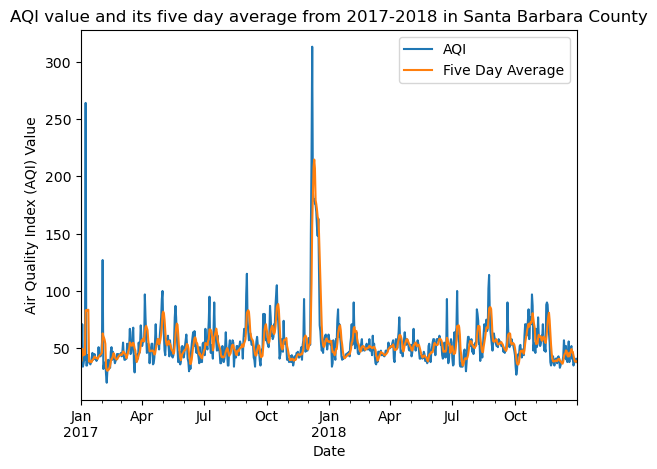

In [7]:
#| code-fold: true
#| code-summary: Show the code

# Initialize empty figure and axis
fig, ax = plt.subplots()

# Plot a df on the axis
aqi_sb.plot(ax=ax)

# Set axis and title names 
ax.set_title('AQI value and its five day average from 2017-2018 in Santa Barbara County')
ax.set_xlabel('Date')
ax.set_ylabel('Air Quality Index (AQI) Value')

# Change legend variable names
plt.legend(labels = ['AQI', 'Five Day Average'])

# Display figure
plt.show()

Our plot shows a huge spike in both our AQI and five day average during the 2017 Thomas Fire. From [Airnow's](https://www.airnow.gov/aqi/aqi-basics/) AQI, we know that healthy, moderate, and unhealthy values range from 0-50, 51-100, and 150-200 respectively. During the 2017 Thomas Fire we see an AQI value reaching over 300 which is the highest level of concern. Values of 300 or more translate to emergency health conditions, where everyone is more than likely to be affected. 

## Landsat and Fire Perimeter Data

#### Fire Perimeter Data Cleaning

We have already loaded in our California fire perimeter data. We are interested in looking at the geospatial element of the 2017 Thomas Fire. Like before, we want to explore this data and clean it up. The file that we loaded in was a shapefile, so we expect to see a spatial component. Let's take a look.

In [8]:
# View the variables within our dataframe 
perimeters.head()

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,C_METHOD,OBJECTIVE,GIS_ACRES,COMMENTS,COMPLEX_NA,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,geometry
0,2023,CA,CDF,SKU,WHITWORTH,00004808,2023-06-17,2023-06-17,5,1,1,5.72913,None,None,{7985848C-0AC2-4BA4-8F0E-29F778652E61},None,None,2020,"POLYGON ((-13682443.000 5091132.739, -13682445..."
1,2023,CA,LRA,BTU,KAISER,00010225,2023-06-02,2023-06-02,5,1,1,13.60240,None,None,{43EBCC88-B3AC-48EB-8EF5-417FE0939CCF},None,None,2020,"POLYGON ((-13576727.142 4841226.161, -13576726..."
2,2023,CA,CDF,AEU,JACKSON,00017640,2023-07-01,2023-07-02,2,1,1,27.81450,None,None,{B64E1355-BF1D-441A-95D0-BC1FBB93483B},None,None,2020,"POLYGON ((-13459243.000 4621236.000, -13458968..."
3,2023,CA,CDF,AEU,CARBON,00018821,2023-07-11,2023-07-11,9,1,1,58.76020,None,None,{CB41DB0A-E4B1-489D-A4EA-738F2CD6DB3B},None,None,2020,"POLYGON ((-13468077.000 4642260.000, -13467975..."
4,2023,CA,CDF,AEU,LIBERTY,00018876,2023-07-11,2023-07-12,14,1,1,70.97900,None,None,{F83F70A4-07A7-40B8-BD51-10CCC1C30D63},None,None,2020,"POLYGON ((-13468418.000 4614853.000, -13468428..."


In [9]:
# Check the crs 
perimeters.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

There are a number of variables in this geospatial dataframe. We are interested in the perimeter for the 2017 Thomas Fire. So, the columns we need are year, fire name, and it's geometry. From our preliminary exploration, we can see that we have all three of those components. Let's clean up the data and then filter down to the 2017 Thomas Fire. Note that we only need to change the column letters from uppercase to lowercase. They already have `_` instead of spaces. After, we can filter down to the 2017 Thomas Fire.

In [10]:
#| code-fold: true
#| code-summary: Show the code

# Select the data frame's columns and lowercase them
perimeters.columns = perimeters.columns.str.lower()

# Select the Thomas Fire Boundary in 2017
thomas_perimeter = perimeters[(perimeters['fire_name'] == 'THOMAS') 
                              & (perimeters['year_'] == 2017)]

### Landsat exploration

The landsat data was read in using `open_rasterio` from the `rioxarray` package. The format of this information is different from the `DataFrame` and `GeoSpatialDataFrame` we have seen in the past. We do not need to use any exploratory methods such as `head` and `info`. All of the information is contained within the array. We just need to call the variable to view it. Let's take a look.

In [11]:
# View the dataframe
landsat

<xarray.Dataset> Size: 25MB
Dimensions:      (band: 1, x: 870, y: 731)
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int32 4B 0
Data variables:
    red          (band, y, x) float64 5MB ...
    green        (band, y, x) float64 5MB ...
    blue         (band, y, x) float64 5MB ...
    nir08        (band, y, x) float64 5MB ...
    swir22       (band, y, x) float64 5MB ...

Notice, there are 4 coordinates, consisting of a `band`, `x`, `y`, and `spatial_ref`. There are 5 data variables `red`, `green`, `blue`, `nir08`, and `swir22` that represent band types. There are 3 dimensions `band`, `x`, and `y`. There is also an index consisting of `band`, `x`, and `y`. There are options to show/hide the information contained within the coordinates and variables.

## Landsat cleaning

Notice that there is only a value of one in the band dimension. Since there is only one band, we do not need to specify it as a dimension. We can filter this out from our array using the following methods.

In [12]:
#| code-fold: true
#| code-summary: Show the code

# Drop the `band` coordinate of the data
landsat = landsat.drop_vars('band')

# Drop the `band` dimension of the data
# The code `squeeze` drops dimensions with values of 1 
landsat = landsat.squeeze()

# Check our array to confirm that `band` has been 
# removed from the dimensions and coordinates
landsat

<xarray.Dataset> Size: 25MB
Dimensions:      (x: 870, y: 731)
Coordinates:
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int32 4B 0
Data variables:
    red          (y, x) float64 5MB ...
    green        (y, x) float64 5MB ...
    blue         (y, x) float64 5MB ...
    nir08        (y, x) float64 5MB ...
    swir22       (y, x) float64 5MB ...

Whenever you are working with spatial data, you always want the CRSs to be the same. Otherwise, the spatial data won't be able to communicate properly with one another. We know that the Thomas Fire is projected to EPSG:3857. Let's reproject our landsat data to the same CRS.

In [13]:
#| code-fold: true
#| code-summary: Show the code

# Reproject our landsat data to EPSG:3857
landsat = landsat.rio.reproject("EPSG:3857")

# Check to see if the CRSs are the same
# By using assert we shouldn't see an output
assert landsat.rio.crs == thomas_perimeter.crs

### Let's create our false color image now

To do so we need to change the type of bands that we are plotting. We want to select the short-wave infrared (swir22), near-infrared (nir08), and red bands to the red, green, and blue colors respectively. This will give us our false color image.

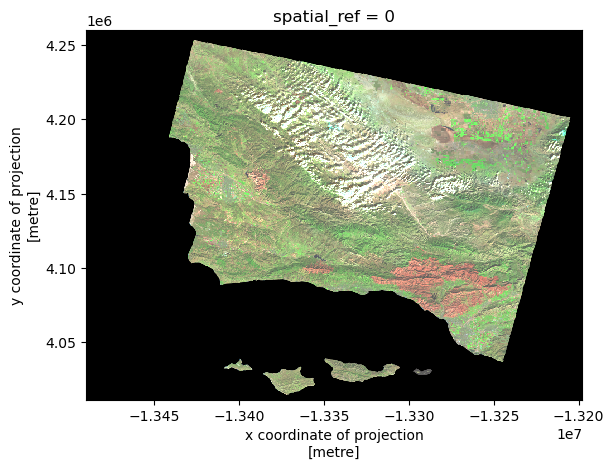

In [14]:
#| code-fold: true
#| code-summary: Show the code

# Select swir22, nir08, and red as the variables to be plotted 
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)

## Step 6: Add the Thomas Fire perimeter to our false color image

We want to combine our Thomas Fire perimeter with our landsat plot to help us visualize where the fire boundary is. The CRSs are both `EPSG:3857` so they should be able to plot with one another without any problems. The first thing we need to do is assign a variable name to our false color image that we created above. Then, we can plot both maps together.

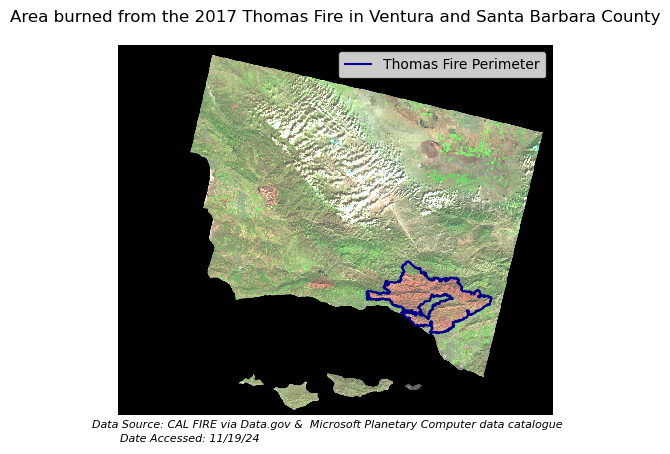

In [15]:
#| code-fold: true
#| code-summary: Show the code

# Create a variable for the false color image map
false_color = landsat[['swir22', 'nir08', 'red']].to_array()

# Set up fig and ax
fig, ax = plt.subplots()

# False color image map
false_color.plot.imshow(robust = True, 
                        ax = ax,
                       alpha = 1)

# Fire perimeters
thomas_perimeter.boundary.plot(ax=ax,
                              color = 'darkblue')
                             
# Add a legend for the fire perimeter
ax.legend(labels = ['Thomas Fire Perimeter'])

# Add a title 
plt.title("Area burned from the 2017 Thomas Fire in Ventura and Santa Barbara County")
ax.axis('off')

# Add footnote citation at the bottom of the figure
fig.text(0.5, 0.09, 
         'Data Source: CAL FIRE via Data.gov &  Microsoft Planetary Computer data catalogue',
         ha='center', va='center', fontsize=8, color='black', fontstyle='italic')

fig.text(0.395, 0.06, 
         'Date Accessed: 11/19/24',
         ha='right', va='center', fontsize=8, color='black', fontstyle='italic')


plt.show()

This false color image does a great job of identifying the burned area from the 2017 Thomas Fire, as indicated in red. Having the Thomas Fire boundary layered over top of the image depicts the burned area even more. Remote sensing has become an important part of detecting, monitoring, and acting on wildfire outbreaks. This is just one example of the power that can be harnessed from satellite data.

This workflow depicts the area burned and the dramatic increase of PM 2.5 in air quality during the 2017 Thomas Fire. Visualizing the burn scar and API reminds us of the devastating affects those in Ventura and Santa Barbara counties faced in 2017. 

## References & data sources

AQI Data: Available from: (https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI.) Access date: October 23, 2024

Microsoft Planetary Computer Data Catalogue, Landsat collection 2 Level-2. Available from: (https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2.) Access date: November 19, 2024.

Data.gov Data Catalogue, California Fire Perimeters (all). Available from: (https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436.) Access date: November 19, 2024.

#### Ackowledgements
Materials created by [Carmen Galaz-Garcia](https://github.com/carmengg) for EDS-220: [Working with Environmental Data](https://meds-eds-220.github.io/MEDS-eds-220-course/)